#  Geolocation

- formulation of a solver.

- statistical simulations in order to determine sources of uncertainty

---

# 1 - Formulation

<img src='schematic.jpeg' alt='Drawing' align='right' style='width: 300px;'/>

We want to find the float horizontal position $\underline{x}$ of an underwater float 
given a number of **known variables**:
- $\underline{x}_s^i$ : source surface float horizontal position
- $t_e^i$ : time of emission for source $i$
- $\tilde{t}_r^i$ : time of reception of the signal emitted by source $i$ by the underwater float
- $\epsilon_i$ : signal detection, $\epsilon_i=1$ (detection) or $1$ (no detection)
- $z$ : underwater float depth(perfect knowledge), not used for now

'Perfect' knowledge is assumed for known variables wich amounts to say potential errors on there
estimates may be neglected.

---
**Unknown variables** are:
- $\underline{x}$ : underwater float position
- $\delta t$ : underwater float clock offset, $\delta t = \tilde{t}_r^i - t_r^i$, where 
$t_r^i$ is the true time of reception
- $\delta \underline{x}^i$ : vector difference between source $i$ transducer position and surface float position, $\delta \underline{x}^i = \underline{x}_t^i - \underline{x}_s^i$
- $\delta t_p (\underline{x},\underline{x}_t^i)$ : difference between actual $(t_r^i - t_e^i)$ and an priori time $t_p(\underline{x},\underline{x}_t^i)$ of propagation between $\underline{x}$ and $\underline{x}_t^i$.

For simplicity, we assume the assumed propagation time is a function of range only: $t_p(\underline{x},\underline{x}_t^i) = t_p(|| \underline{x} - \underline{x}_t^i ||)$.

$t_p$ may for example be given by an a priori estimate of velocity ($c_b$) along with a measure of velocity uncertainty ($e_c$). In this case, we expect the error on time to grow with range according to: $e_{tp} \propto || \underline{x}_b - \underline{x}_t^i || /e_c$, where $\underline{x}_b$ is an a priori estimate for the float location.

A priori standard deviations for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p  (\underline{x},\underline{x}_t^i)$ are
assumed to be known and given by: $e_x$, $e_{\delta x}$, $e_{tp}$.

Background (a priori) estimates for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p (\underline{x},\underline{x}_t^i)$ may eventually be provided. We assume all are 0 for now except
for the float position $\underline{x}_b=(x=1km, y=0km)$.


---
The estimate of the underwater float position $\underline{\hat{x}}$ minimizes:

$$
\begin{align*}
J(\mathbf{x}, \delta t) &= 
||\underline{x} - \underline{x}_b||^2 /e_x^2 
+ \sum_i \epsilon_i \times  \delta t (\underline{x},\underline{x}_t^i)^2 / e_{tp}^2 \\
&= 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \sum_i \epsilon_i \times \big [ \tilde{t}_r^i - \delta t  - t_e^i  -  t_p(\underline{x},\underline{x}_t^i) \big ]^2 / e_{tp}^2
\end{align*}
$$

We assume $\epsilon_i=1$ in all examples below for simplicity.

We have assumed simultaneous (working assumption) emission of sources.
The underwater float velocity may be added as an extra variable (future addition).

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt

from clib.geolocation_1D import *


---
# 2 - Create an ensemble of sources

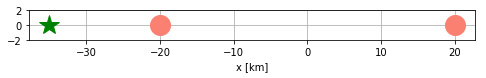

In [3]:
### create an ensemble of sources
dx=40. *1.e3 # in meters
sources=[]
sources.append(source( dx*.5, 0))
sources.append(source(-dx*.5, 0))



Ns = len(sources)

### init a receiver
#r=receiver(0. *1.e3, 0. *1.e3, e_x=10.e3)
r=receiver(-35. *1.e3, 0, e_x=10.e3, e_dt=0.)

### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_min=1.e-3)  #e_min on time (Cramer-Rao)

### plot
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
plt.ylim([-2, 2])
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.show()

**- A priori uncertainties and estimates are :**

In [13]:
# a priori uncertainties : 
print("e_c   = %.1f m/s    (uncertainty on celerity)" %pmap.e_c)
# si e_c = 0 alors e_tp = e_min = 1.e-3 s
print("e_dx  = %.1f m     (uncertainty on transducer position)" %sources[0].e_dx)
print("e_x   = %.1f m  (uncertainty on underwater float position)" %r.e_x)

e_c   = 0.0 m/s    (uncertainty on celerity)
e_dx  = 10.0 m     (uncertainty on transducer position)
e_x   = 10000.0 m  (uncertainty on underwater float position)


---
# 3 - Statistical simulations for 1 receiver position

For each source-receiver acoustic path, a random value of c is drawn around **c_b = 1500m/s**.
The standard deviation of the celerity is **e_c = 10 m/s**.

**- The true underwater float position and clock offset are:**

In [7]:
print('x = %.1f m \ndt = %.2e s' %(r.x, r.dt))

x = -35000.0 m 
dt = -0.00e+00 s


**- Unchanged variables during simulations are : **

In [174]:
print("s.x_t :", [s.x_t for s in sources])   # 
#print("s.y_t :", [s.y_t for s in sources])
print("s.dx  :", [s.dx for s in sources])
#print("s.dy  :", [s.dy for s in sources])
#print("r.dt  :", r.dt)

s.x_t : [array([20009.46792613]), array([-19997.39470569])]
s.dx  : [array([9.46792613]), array([2.60529431])]


## A - Unique geolocalisation

In [175]:
r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
r.t_r_tilda

array([36.66748277, 10.00171943])

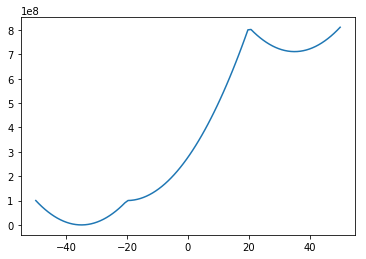

In [176]:
#r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
x, dt, success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)

In [177]:
print ("L'erreur sur la geolocalisation est de %.2f m." %(r.x - x))

L'erreur sur la geolocalisation est de 1.91 m.


In [178]:
x

-35001.906250000044

In [179]:
r.x

-35000.0

## B - Statistical simulations

**- Simulations : only celerity between receiver and each source is changing** 

In [23]:
### minimization with adjusted a priori estimates
Nmc = 1000
x=np.zeros(Nmc)
y=np.zeros(Nmc)
dt=np.zeros(Nmc)
su=np.zeros(Nmc)

for i in range(Nmc):
    # solve a first time
    r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
    x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)
    # rerun with adjusted expected errors on propagation time
    for j in range(1):
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False, \
                                                                     x0=[x[i], dt[i]])

d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
bias_x = x.mean()-r.x
bias_y = y.mean()-r.y
print('\nrms error, x bias, y bias: %.1fm, %.1fm, %.1fm ' %(d_rms, bias_x, bias_y))


rms error, x bias, y bias: 1.5m, 0.0m, 0.0m 


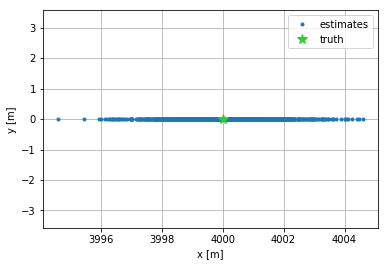

In [24]:
plt.figure()
ax=plt.subplot(111)
ax.plot(x,np.zeros(Nmc),'.', label='estimates')
ax.plot(r.x,r.y,'*', color='limegreen', markersize=10, label='truth')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()

---
# 4 - Transects 

**- Function "simu" : simulations for one receiver position ; returns rms and bias.  **

In [180]:
def simu (r, sources, Nmc, var) : 
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    su = np.zeros (Nmc)
    
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        
        # solve a first time
        r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)
        # rerun with adjusted expected errors on propagation time
        for j in range(1):
            x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, \
                                                                         clock_drift=False, \
                                                                         x0=[x[i], dt[i]])
        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            # "Warning: Maximum number of iterations has been exceeded."
            su[i] = -1
        elif message.find('precision loss')!= -1 :
            #Warning: Desired error not necessarily achieved due to precision loss.
            su[i] = -2
        else : 
            su[i] = -3
    
    
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2  + (y[np.where(su==1)] - r.y)**2 ) )
    # biais on the receiver position
    biais_x = x[np.where(su==1)].mean()-r.x
    biais_y = y[np.where(su==1)].mean()-r.y
    #biais = np.sqrt(biais_x**2 + biais_y**2)
    return (d_rms, bias_x, bias_y, su)

**- Calculation and plot functions for transects : **

In [181]:
from sys import stdout
import time

def transect (sources, X, Y, Nmc, var) :
    RMS_t = np.zeros((len(X)))
    BiasX_t = np.zeros((len(X)))
    BiasY_t = np.zeros((len(X)))
    Success_t = np.zeros((Nmc, len(X)))
    for i in range (len(X)) :
        # init a receiver
        r = receiver(X[i], Y)
        r.dt = 1. # unchanged variable during simulations 
        #
        d_rms, bias_x, bias_y, su = simu (r, sources, Nmc, var = var)

        RMS_t[i]       = d_rms
        BiasX_t[i]     = bias_x
        BiasY_t[i]     = bias_y
        Success_t[:,i] = su
        
        ### avancement dans la boucle
        print ("%.1f" %(i/len(X)*100)+'%')
        stdout.flush()
        time.sleep(0.1)    
        
    
    return RMS_t, BiasX_t, BiasY_t, Success_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('min (rms) = %.1f m' %np.min(RMS_t))
    print('min (bias) = %.1f m' %np.min(Biais_t))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error along the transect Y=%.dkm' %int(Y/1000.))
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias along the transect Y=%.dkm' %int(Y/1000.))
    
    plt.show()

**- Creation of a transect : **

In [46]:
L = 80.* 1.e3
X = np.linspace(-L/2.,L/2.,200)  # resolution : 400m
Y = 0. 

**A - Distance between sources : 10km, with Y=0 km **

In [47]:
Nmc = 1000          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, BiasY_t, Success_t = transect (sources, X, Y, Nmc, var)

min (rms) = 1.4 m
min (bias) = 0.0 m


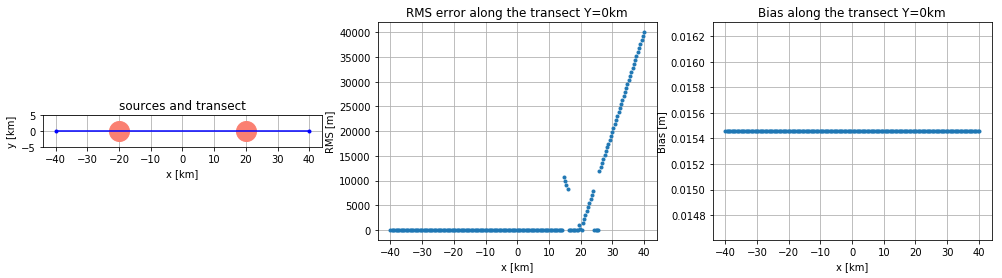

In [48]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

In [60]:
sort = sorted(RMS_t)
sort[-100:]

[1.508564502778315,
 1.5086377627919108,
 1.5086696983145347,
 1.5093288858280294,
 1.5108280732562358,
 1.511365188005796,
 1.511437786511191,
 1.511536678916371,
 1.5126654985049257,
 1.5134482961045164,
 1.5134867885893317,
 1.5136374363717273,
 1.5157313132179495,
 1.516112564063192,
 1.516286681533454,
 1.5175007431885623,
 1.5181332827865688,
 1.5186399998242168,
 1.5208942063048383,
 1.522148918431401,
 1.522865515813333,
 1.5254079143334638,
 1.5257616382544825,
 1.5261614491809514,
 1.5267928417020336,
 1.5295104669238309,
 1.5297600730758045,
 1.531063310522627,
 1.5321244287087146,
 1.532256567768117,
 1.5323761131158022,
 1.5325865673678587,
 1.5333362817822904,
 1.5342550969236572,
 1.5364098980213021,
 1.5368729862210164,
 1.5384878704657572,
 1.5394007929504228,
 1.542083443902046,
 1.5441334545962775,
 1.5450937775288272,
 1.5453890960992431,
 1.545933951479653,
 1.5459588160693447,
 1.5486504680985969,
 1.549113358091875,
 1.5500068433501724,
 1.5609171364769554,
 1.56

In [59]:
rej = np.where(Success_t != 1)[0].size
tot = Success_t.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


In [182]:
L = 80.* 1.e3
X = np.linspace(-L/2.,L/2.,80)  # resolution : 1km
Y = 0. 

0.0%
1.2%
2.5%
3.8%
5.0%
6.2%
7.5%
8.8%
10.0%
11.2%
12.5%
13.8%
15.0%
16.2%
17.5%
18.8%
20.0%
21.2%
22.5%
23.8%
25.0%
26.2%
27.5%
28.7%
30.0%
31.2%
32.5%
33.8%
35.0%
36.2%
37.5%
38.8%
40.0%
41.2%
42.5%
43.8%
45.0%
46.2%
47.5%
48.8%
50.0%
51.2%
52.5%
53.8%
55.0%
56.2%
57.5%
58.8%
60.0%
61.3%
62.5%
63.7%
65.0%
66.2%
67.5%
68.8%
70.0%
71.2%
72.5%
73.8%
75.0%
76.2%
77.5%
78.8%
80.0%
81.2%
82.5%
83.8%
85.0%
86.2%
87.5%
88.8%
90.0%
91.2%
92.5%
93.8%
95.0%
96.2%
97.5%
98.8%


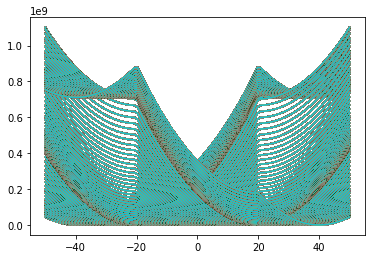

In [183]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, BiasY_t, Success_t = transect (sources, X, Y, Nmc, var)

min (rms) = 0.9 m
min (bias) = 0.0 m


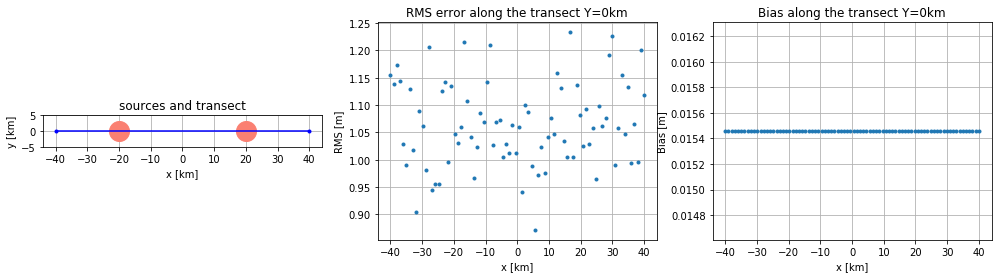

In [184]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

2 -  changé définition des erreurs. Prendre un e_tp constant et pas dépendant du range (prend e_tp en utilisant les écart-type de la célérité eq). Commencer en prenant e-tp = 10**-2, puis 10**-1, .....

3 - dérive d'horloge (mais plus petite que 1s)

4 - ajouter de nouvelles sources (toujours en 1D)

5 - 

In [ ]:
for i, s in enumerate(sources):
    print('Distance source %d - float = %.2f km' %(i, dist(s,r)/1.e3))
    print('    - Horizontal offset for a sound celerity difference of %.1f m/s = %.2f m' %(pmap.e_c, dist(s,r)*pmap.e_c/pmap.c_b))
    print('    - Corresponding propagation time uncertainty %.2e s \n' %(dist(s,r)*pmap.e_c/pmap.c_b**2))    